In [4]:
import os
import numpy as np
from os import listdir
from matplotlib.pyplot import imread
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from PIL import Image
import math
import cv2
import matplotlib.pyplot as plt
from matplotlib.cm import *
from scipy.signal import convolve2d as conv2, convolve
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Pool

from PIL import Image



plt.rcParams['figure.figsize'] = (20, 8)

In [107]:
AVAILABLE_CPU = multiprocessing.cpu_count()

In [53]:
# Settings:
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2


def get_img(data_path):
    # Getting image array from path:
    img = imread(data_path)
    img = resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img


def get_dataset(dataset_path='Dataset'):
    # Getting all data from data path:
    try:
        X = np.load('X.npy')
        Y = np.load('Y.npy')
    except:
        labels = ['0','1','2','3','4','5','6','7','8','9']  # Geting labels
        X = []
        Y = []
        for i, label in enumerate(labels):
            datas_path = dataset_path + '/' + label
            for data in listdir(datas_path):
                img = get_img(datas_path + '/' + data)
                X.append(img)
                Y.append(i)
        # Create dateset:
        X = np.array(X).astype('float32')
        Y = np.array(Y).astype('float32')
        Y = to_categorical(Y, num_class)
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/')
        np.save('npy_dataset/X.npy', X)
        np.save('npy_dataset/Y.npy', Y)
    
    X_unf = np.copy(X)    
    X = np.array([X[i].flatten() for i in range(len(X))])
    Y = np.where(Y==1)[1]
    permutation = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}
    for i in range(len(Y)):
        Y[i] = permutation[Y[i]]
        
    return X, X_unf, Y


if __name__ == '__main__':
    X, X_unf, Y = get_dataset()

In [12]:
# cleaning
subset = [0,1,2,3,4,5,6,7,8,9,10,53,54,55,56,57,58,59,60,61,62,63]
def cleaning(img, rows):
    for row in rows:
        img[row][0:10] = 1
        img[row][53:64] = 1
    return img

In [13]:
def clean_image(image, threshold = 0.5, new_size_tuple = (64,64)):
    new_img = []
    for el in image.flat: 
        if el > threshold: new_img.append(1)
        else: new_img.append(0)
        
    return np.array(new_img)

In [14]:
img = X[0]
    
new_img = clean_image(img)

8


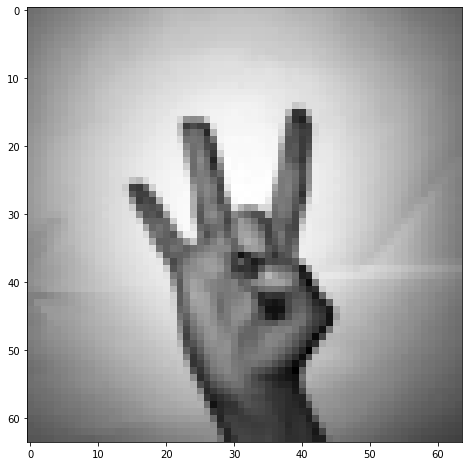

In [44]:
idx = 1200
print(Y[idx])
plt.imshow(X[idx].reshape(64, 64), cmap='gray', interpolation='nearest')

# Principal Component Analysis

## Normalization

In [98]:
def standardize_image(X) :
    for idx, x in enumerate(X) :
        mean = np.mean(x)
        std = np.std(x)
        X[idx] = (x - mean) / std

In [99]:
print(X.shape)
standardize_image(X_unf)

(2062, 4096)


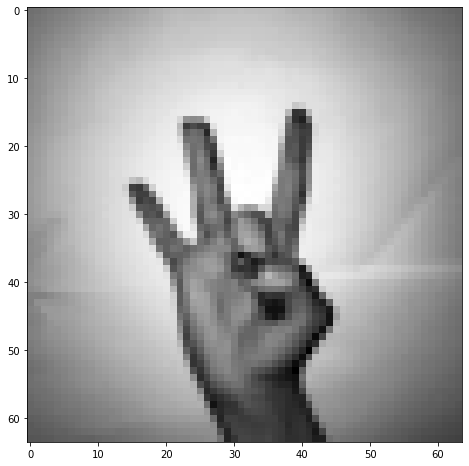

In [100]:
plt.imshow(X_unf[1200].reshape(64, 64), cmap='gray', interpolation='nearest')

In [101]:
ncomp = 64
X_pca = []

for x in X_unf :    
    pca2 = PCA(n_components=ncomp)  # For example 2-PC
    pca2.fit_transform(x)
    X_pca.append(pca2.components_[:5])

X_pca = np.array([X_pca[i].flatten() for i in range(len(X_pca))])
    

# NAIVE BAYES

In [172]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, LeaveOneOut

import naive_bayes_custom

## Gaussian NB

In [ ]:
# working with normal images
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y)

In [ ]:
model = naive_bayes_custom.NaiveBayesCustom()
model.fit(Xtrain, Ytrain)
score = cross_val_score(model, X, Y, cv=20)
Ymodel = model.predict(Xtest)

In [209]:
score.mean()

0.39815712900096994

In [210]:
mat = confusion_matrix(Ytest, Ymodel)

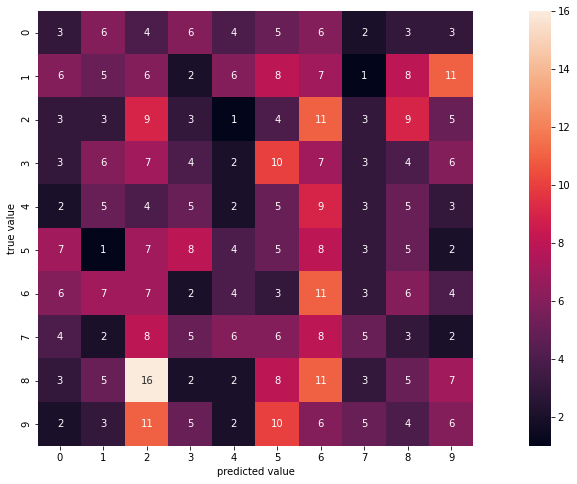

In [211]:
import seaborn as sns

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

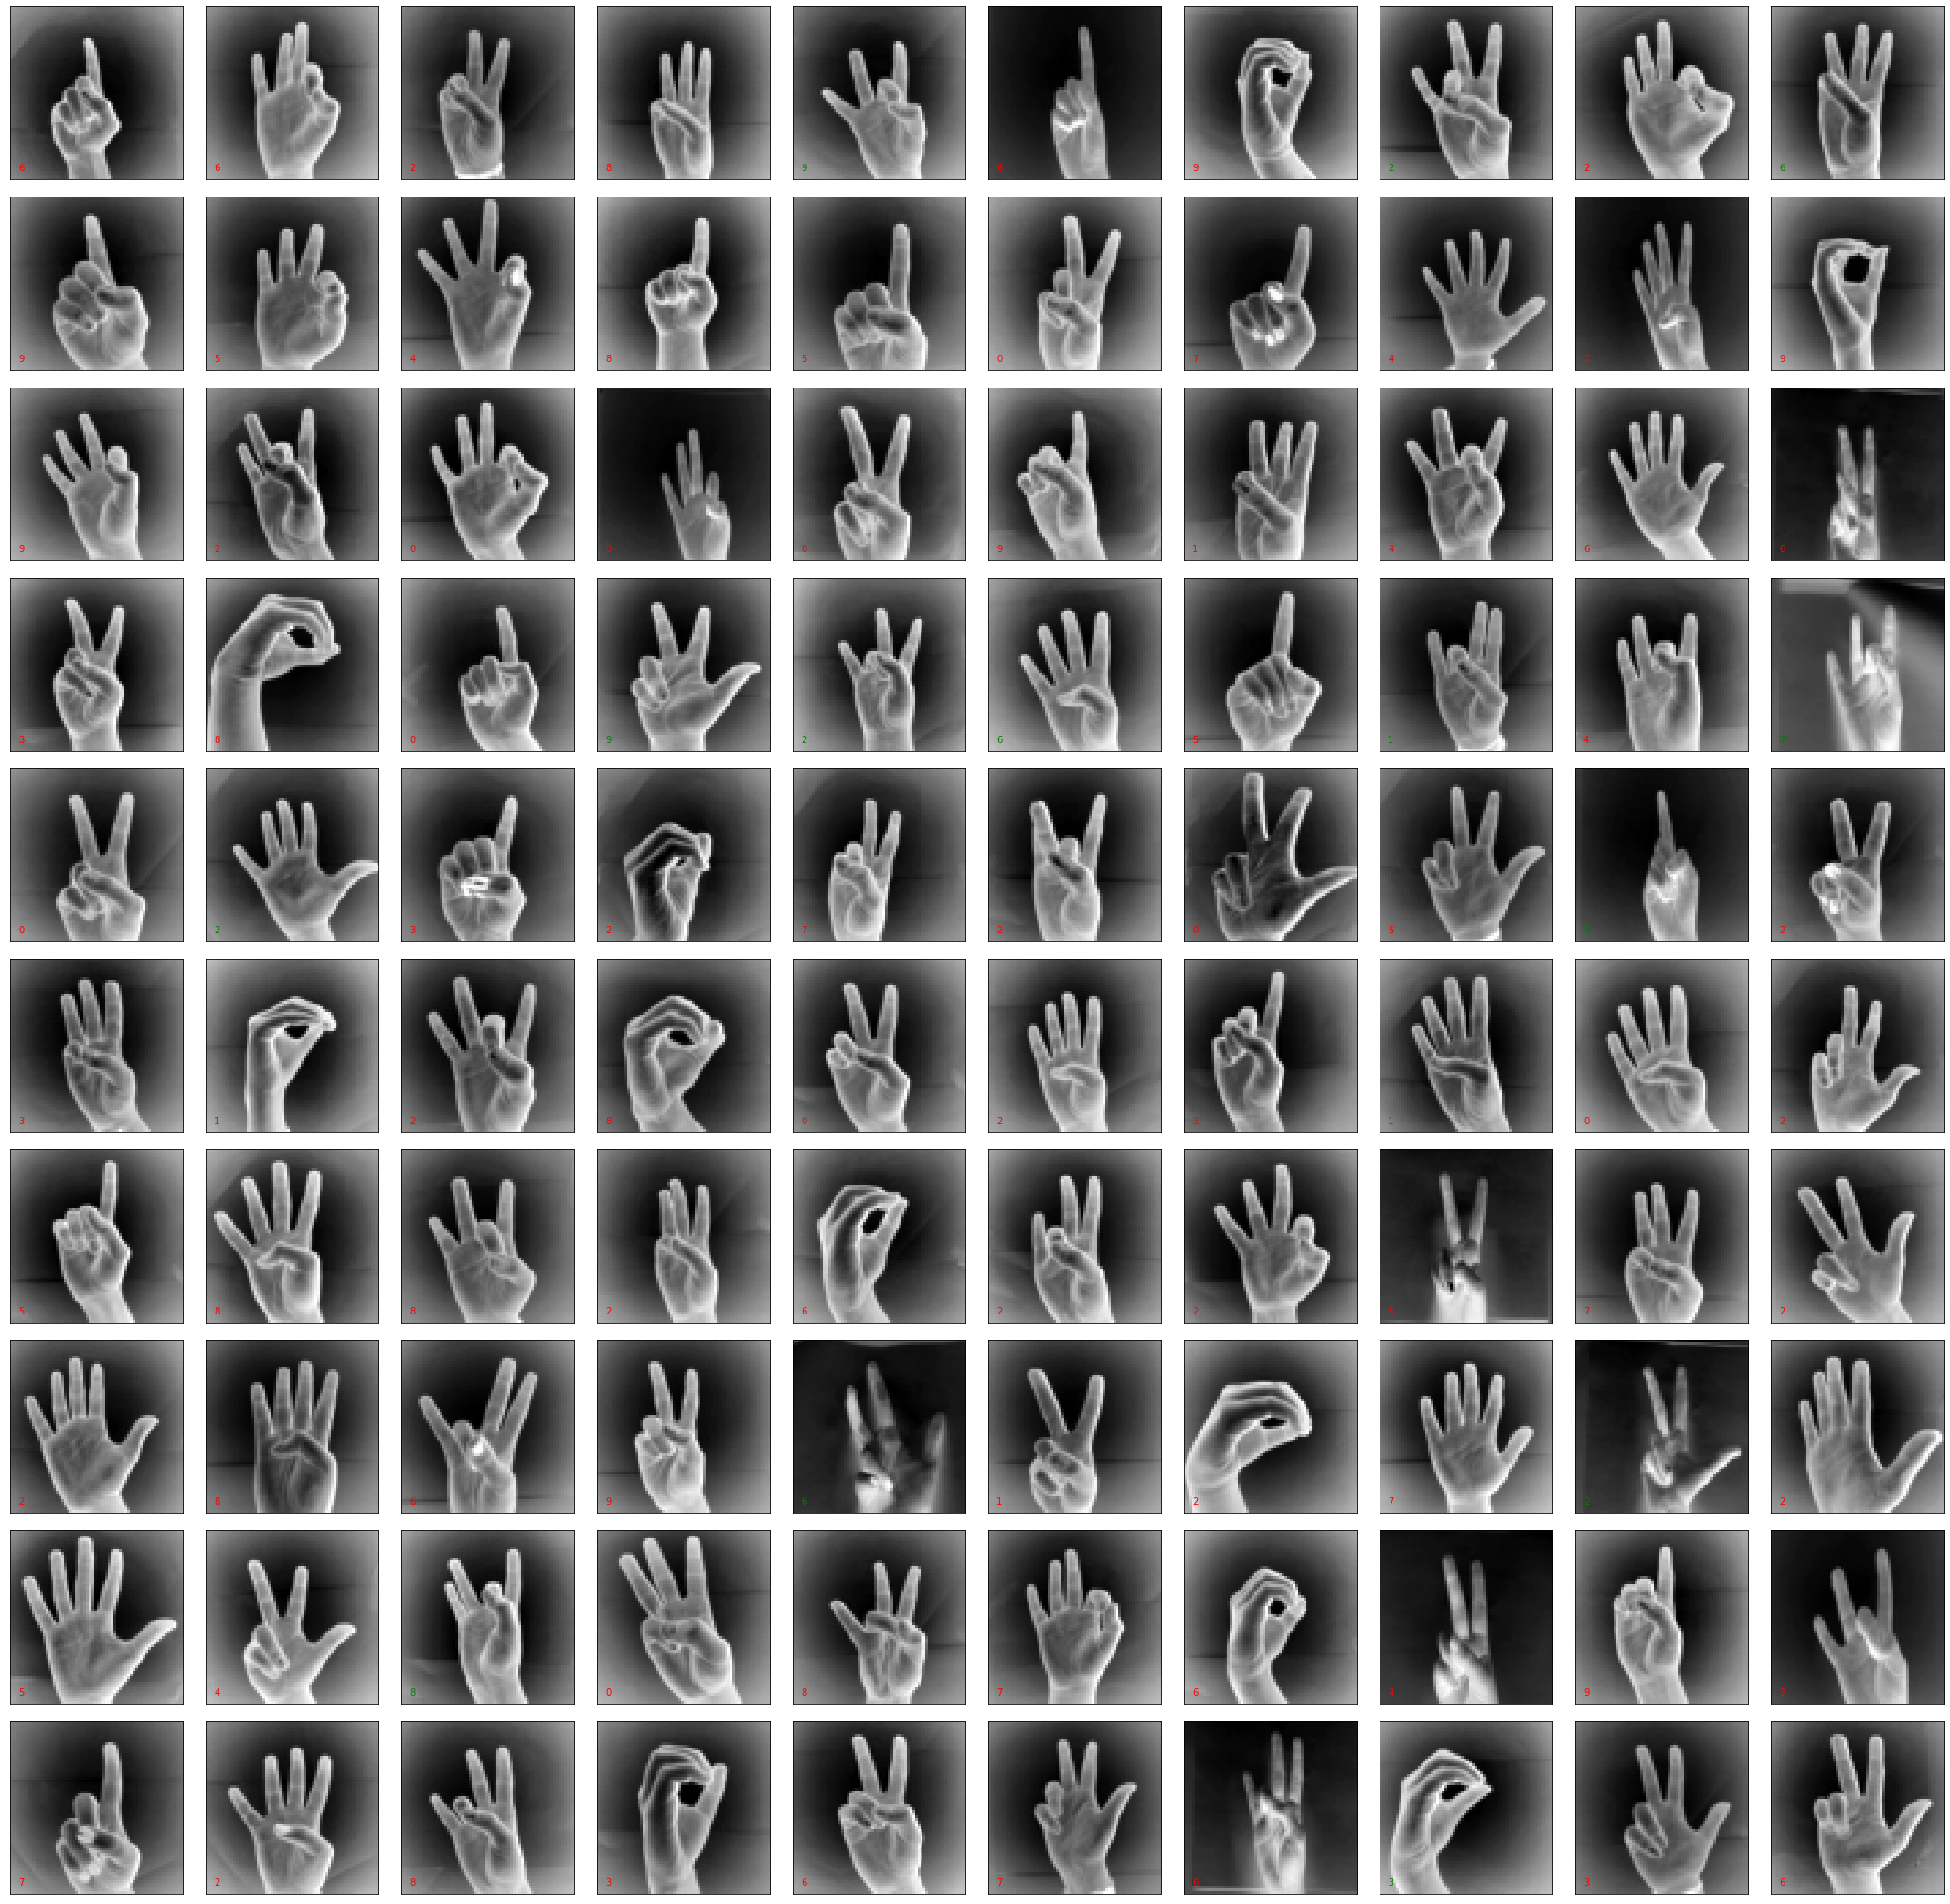

In [212]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes,
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

In [179]:
print(model.predict([Xtest[0]]))

[0]


## GAUSSIAN NB with PCA

In [205]:
# working with normal images
XtrainPCA, XtestPCA, Ytrain, Ytest = train_test_split(X_pca,Y)

In [206]:
model = GaussianNB()
model.fit(XtrainPCA, Ytrain)
score = cross_val_score(model, X_pca, Y, cv=20)
Ymodel = model.predict(XtestPCA)

In [207]:
components_chances = [3, 4, 5, 6, 7, 8, 9, 10, 40]
results = []

for comp_amount in components_chances:
    PCA_matrix = []

    for x_i in X_unf :    
        pca2 = PCA(n_components=64)  # For example 2-PC
        pca2.fit_transform(x_i)
        PCA_matrix.append(pca2.components_[:comp_amount])

    PCA_matrix = np.array([PCA_matrix[i].flatten() for i in range(len(PCA_matrix))])
    X_train, X_test, Y_train, Y_test = train_test_split(PCA_matrix,Y)
    model = GaussianNB()
    model.fit(X_train, Y_train)
    score = cross_val_score(model, PCA_matrix, Y, cv=LeaveOneOut(), n_jobs = AVAILABLE_CPU)
    Ymodel = model.predict(X_test)
    results.append(score.mean())
    

In [208]:
for i in range(len(results)):
    print(f"avg score obtained with {components_chances[i]} components : {results[i]}")

avg score obtained with 3 components : 0.3569350145489816
avg score obtained with 4 components : 0.4282250242483026
avg score obtained with 5 components : 0.43113482056256064
avg score obtained with 6 components : 0.4340446168768186
avg score obtained with 7 components : 0.4325897187196896
avg score obtained with 8 components : 0.4325897187196896
avg score obtained with 9 components : 0.4248302618816683
avg score obtained with 10 components : 0.41561590688651795
avg score obtained with 40 components : 0.39815712900096994


In [209]:
score.mean()

0.39815712900096994

In [210]:
mat = confusion_matrix(Ytest, Ymodel)

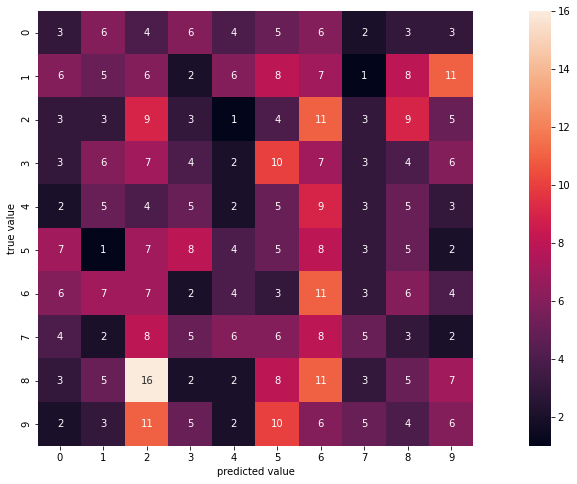

In [211]:
import seaborn as sns

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

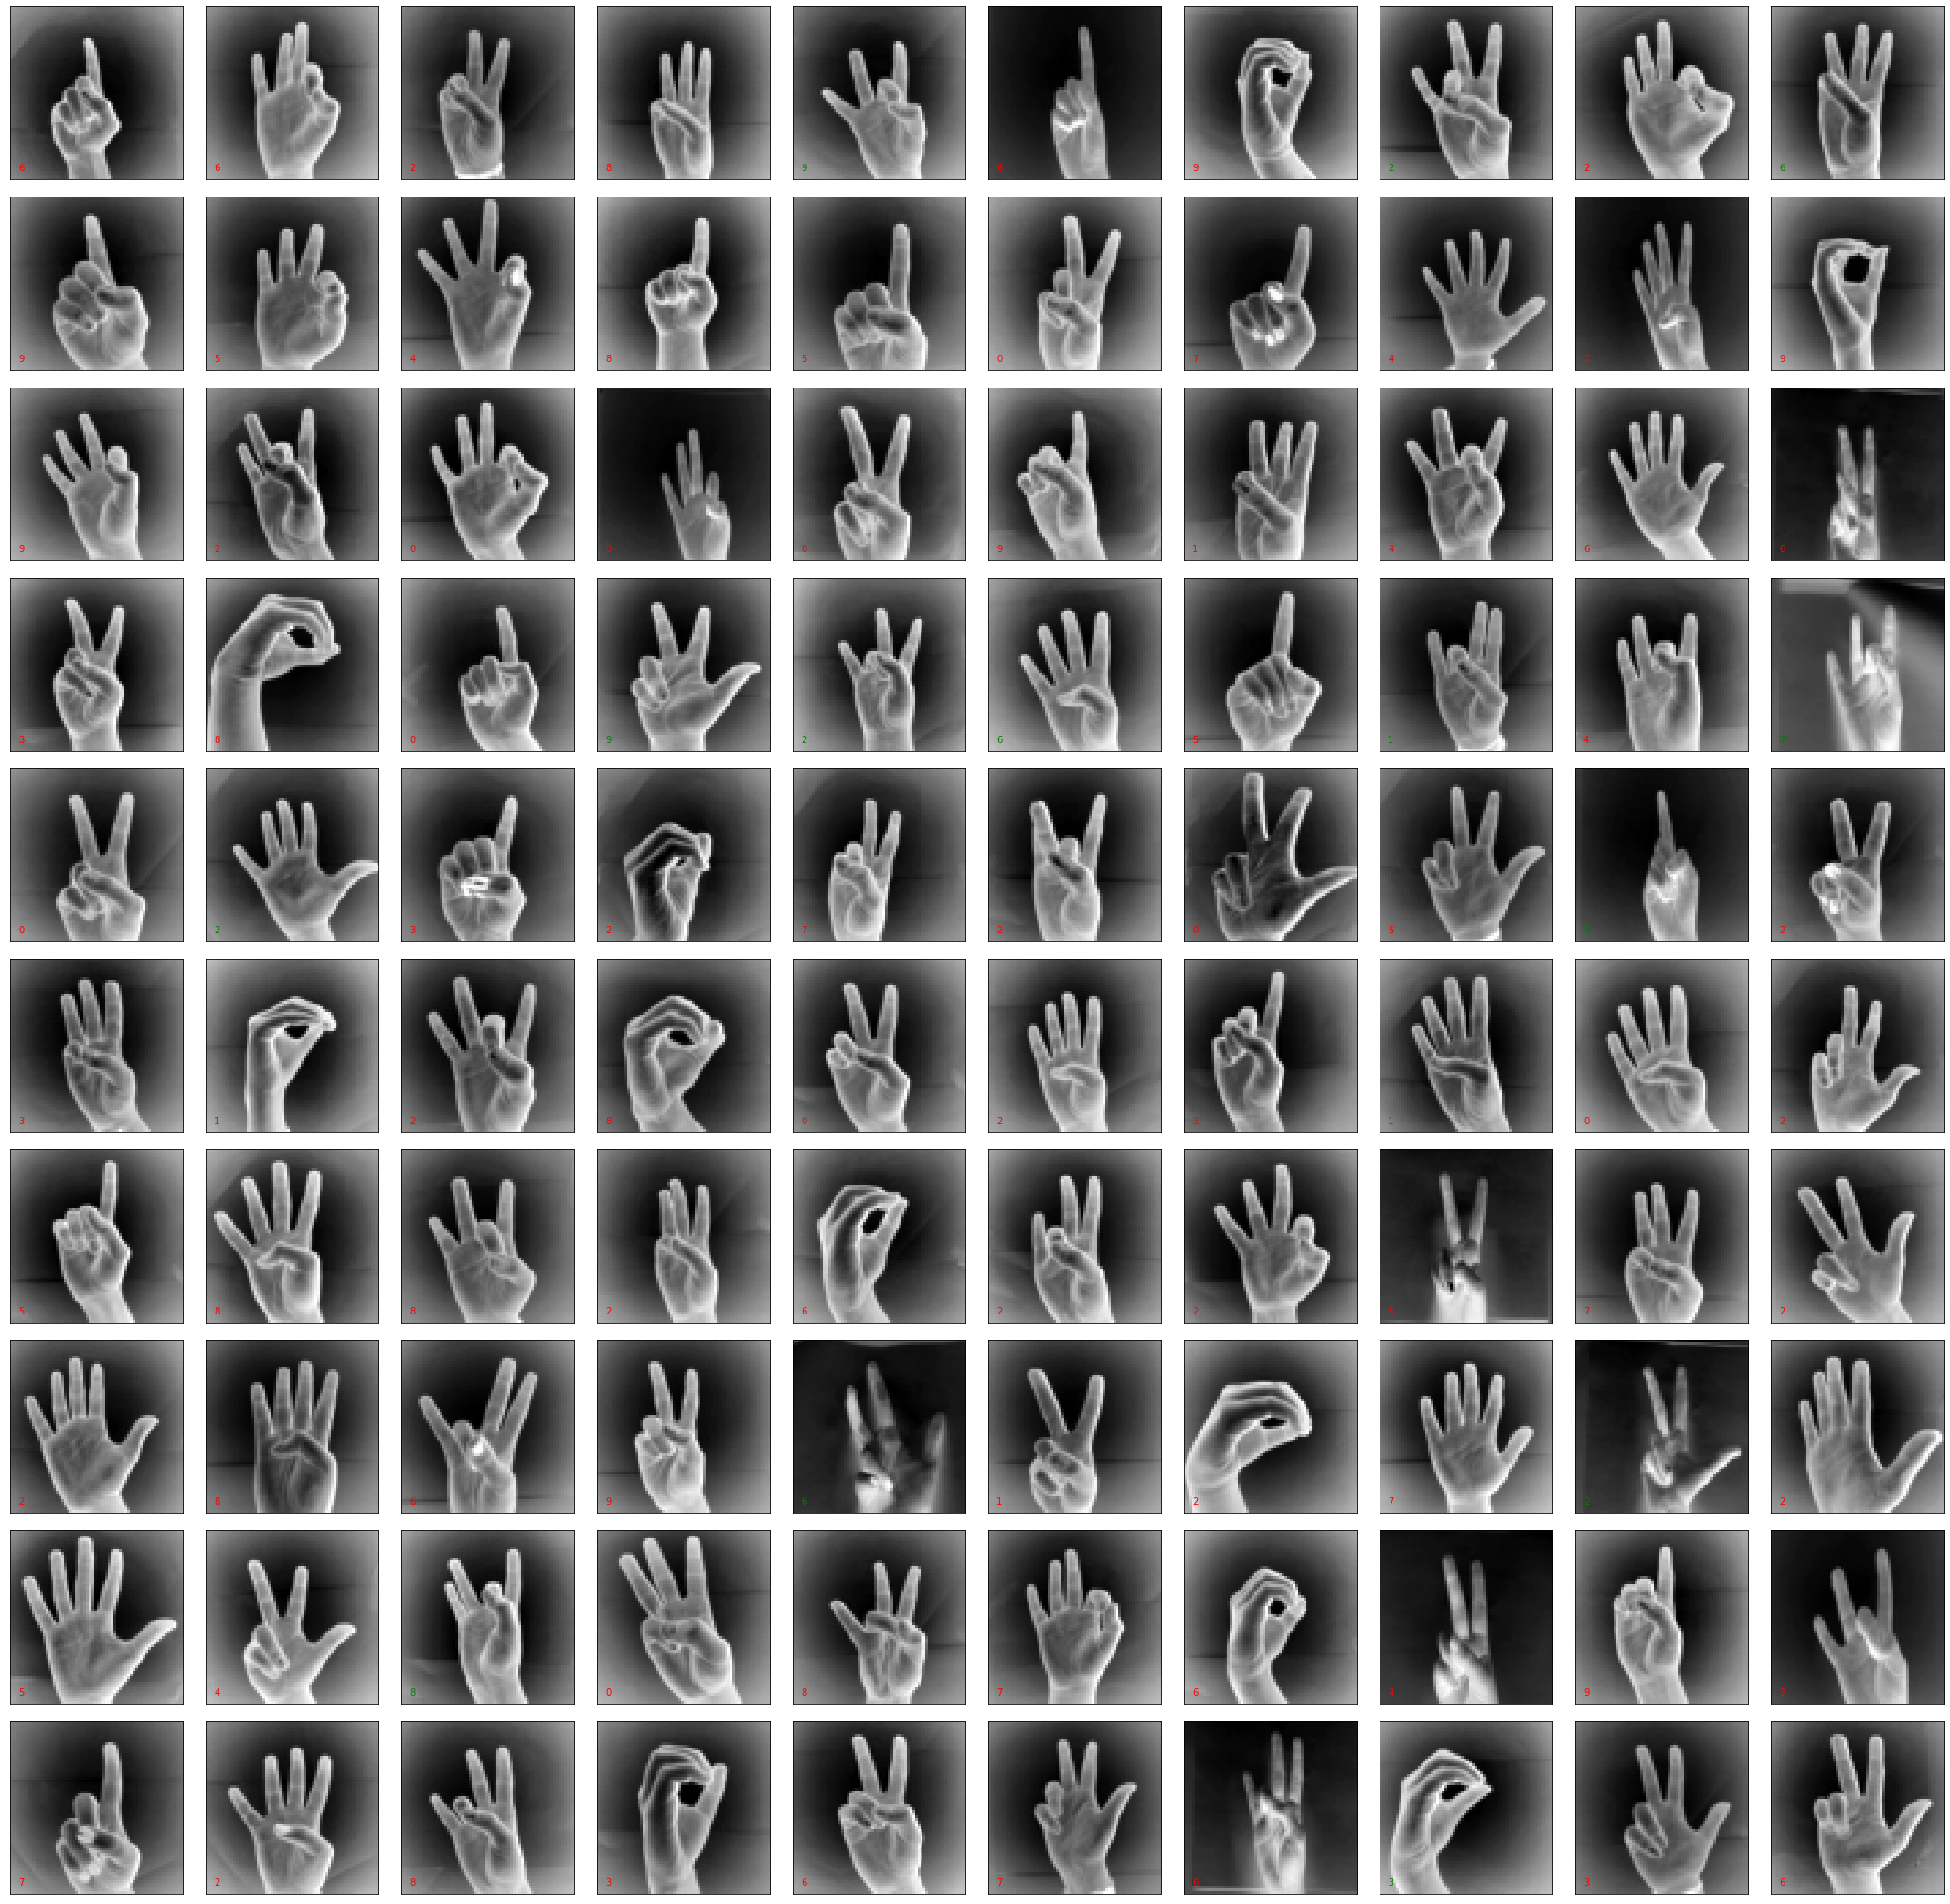

In [212]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes,
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

## Multinomial NB

In [213]:
thresh = np.arange(0.45, 0.61, 0.01)
thresh

array([0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 ])

In [214]:
for threshold in tqdm(thresh):
    
    scores = []
    
    Xbw = [clean_image(X[i], threshold = threshold) for i in range(len(X))]
    Xbwtrain, Xbwtest, Ytrain, Ytest = train_test_split(Xbw,Y)
    modelbw = MultinomialNB()
    modelbw.fit(Xbwtrain, Ytrain)
    
    scorebw = cross_val_score(modelbw, Xbw, Y, cv=20)
    
    scores.append(scorebw.mean())
    
    print(f'score : {scorebw.mean()}, threshold: {threshold}')

  6%|▋         | 1/16 [00:27<06:55, 27.73s/it]

score : 0.4437313293502614, threshold: 0.45


 12%|█▎        | 2/16 [00:55<06:28, 27.78s/it]

score : 0.4481002613890964, threshold: 0.46


 19%|█▉        | 3/16 [01:23<06:00, 27.76s/it]

score : 0.45440160567587756, threshold: 0.47000000000000003


 25%|██▌       | 4/16 [01:51<05:33, 27.78s/it]

score : 0.4631161314413742, threshold: 0.48000000000000004


 31%|███▏      | 5/16 [02:18<05:04, 27.69s/it]

score : 0.4742905153099327, threshold: 0.49000000000000005


 38%|███▊      | 6/16 [02:46<04:36, 27.63s/it]

score : 0.47768857356235994, threshold: 0.5


 44%|████▍     | 7/16 [03:13<04:08, 27.58s/it]

score : 0.48787808065720695, threshold: 0.51


 50%|█████     | 8/16 [03:41<03:41, 27.65s/it]

score : 0.4922470126960419, threshold: 0.52


 56%|█████▋    | 9/16 [04:08<03:13, 27.62s/it]

score : 0.4965972740851382, threshold: 0.53


 62%|██████▎   | 10/16 [04:36<02:45, 27.60s/it]

score : 0.49950522778192685, threshold: 0.54


 69%|██████▉   | 11/16 [05:06<02:21, 28.38s/it]

score : 0.5058019044062734, threshold: 0.55


 75%|███████▌  | 12/16 [05:34<01:53, 28.26s/it]

score : 0.5038694921583271, threshold: 0.56


 81%|████████▏ | 13/16 [06:03<01:25, 28.35s/it]

score : 0.5130927931292008, threshold: 0.5700000000000001


 88%|████████▊ | 14/16 [06:31<00:56, 28.48s/it]

score : 0.5126120238984317, threshold: 0.5800000000000001


 94%|█████████▍| 15/16 [06:59<00:28, 28.33s/it]

score : 0.5092233009708738, threshold: 0.5900000000000001


100%|██████████| 16/16 [07:27<00:00, 27.97s/it]

score : 0.50873786407767, threshold: 0.6000000000000001


In [215]:
Xbw = [clean_image(X[i], threshold = 0.57) for i in range(len(X))]

Xbwtrain, Xbwtest, Ytrain, Ytest = train_test_split(Xbw,Y)
modelbw = MultinomialNB()
modelbw.fit(Xbwtrain, Ytrain)

Ymodelbw = modelbw.predict(Xbwtest)

mat = confusion_matrix(Ytest, Ymodelbw)

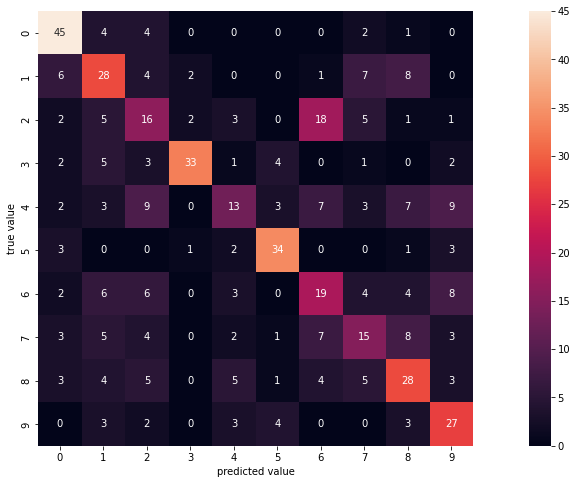

In [ ]:
import seaborn as sns

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

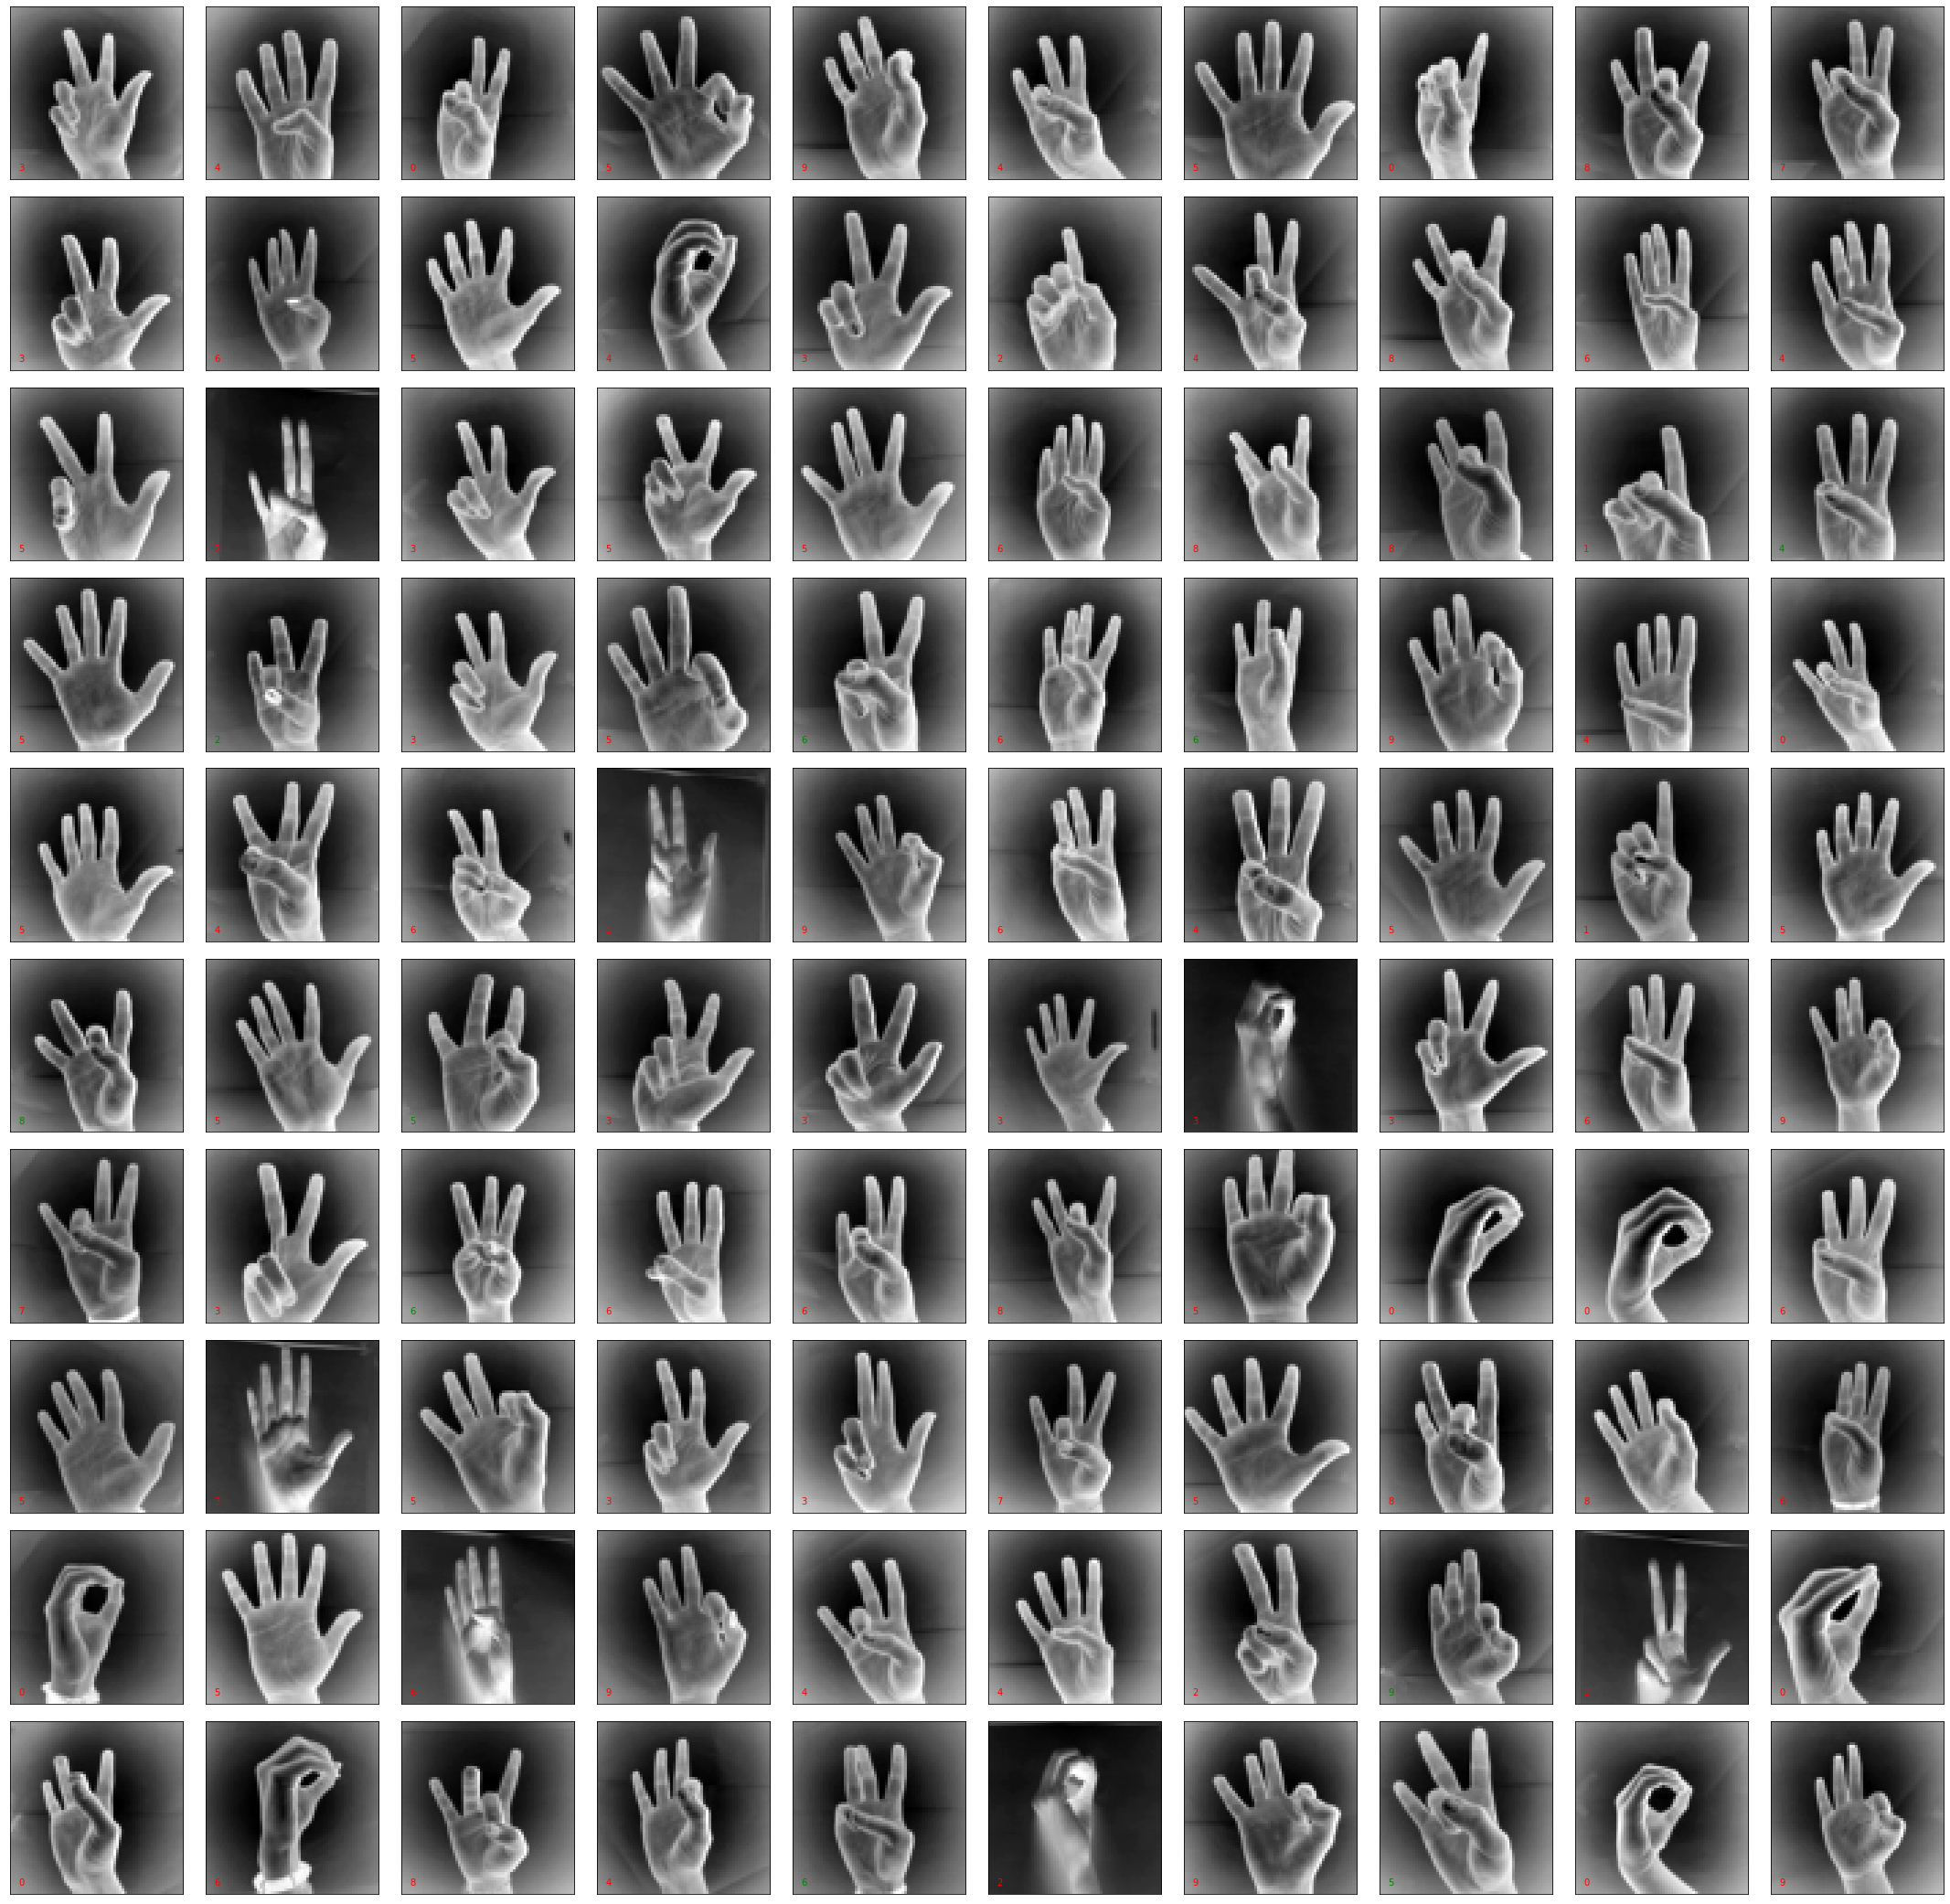

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes,
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

## Custom Gaussian for error understanding

In [ ]:
# working with normal images
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y)

In [ ]:
model = naive_bayes_custom.NaiveBayesCustom()
model.fit(Xtrain, Ytrain)
score = cross_val_score(model, X, Y, cv=20)
Ymodel = model.predict(Xtest)

In [ ]:
img_indexes = np.where(Y == 6)[0]
for img_index in img_indexes :
    #plt.imshow(X[img_index].reshape(64, 64), cmap='gray', interpolation='nearest')
    likes = (model.custom_predict([X[img_index]]))
    top_l = model.classes_[likes[0].argmax()]
    if(top_l != 6):
        print(f"Top likelihood is: {top_l} for index {img_index}")

Top likelihood is: 2 for index 615
Top likelihood is: 8 for index 616
Top likelihood is: 2 for index 617
Top likelihood is: 4 for index 619
Top likelihood is: 2 for index 623
Top likelihood is: 0 for index 626
Top likelihood is: 7 for index 632
Top likelihood is: 2 for index 633
Top likelihood is: 2 for index 635
Top likelihood is: 0 for index 636
Top likelihood is: 4 for index 637
Top likelihood is: 0 for index 638
Top likelihood is: 2 for index 639
Top likelihood is: 0 for index 640
Top likelihood is: 7 for index 641
Top likelihood is: 2 for index 645
Top likelihood is: 0 for index 648
Top likelihood is: 7 for index 650
Top likelihood is: 2 for index 653
Top likelihood is: 2 for index 654
Top likelihood is: 2 for index 655
Top likelihood is: 2 for index 660
Top likelihood is: 9 for index 661
Top likelihood is: 4 for index 664
Top likelihood is: 0 for index 667
Top likelihood is: 2 for index 668
Top likelihood is: 1 for index 670
Top likelihood is: 0 for index 676
Top likelihood is: 2

Top likelihood is: 3 for index 813
Likelihood for class 0 : 2431.7856949387738
Likelihood for class 1 : -3084.7961703096375
Likelihood for class 2 : 1167.730139497847
Likelihood for class 3 : 3234.8730231760055
Likelihood for class 4 : 3083.5097357761347
Likelihood for class 5 : 2686.782396149008
Likelihood for class 6 : 3088.3443102074616
Likelihood for class 7 : 2182.5105516268814
Likelihood for class 8 : 2682.557167979319
Likelihood for class 9 : 2727.0063644622705


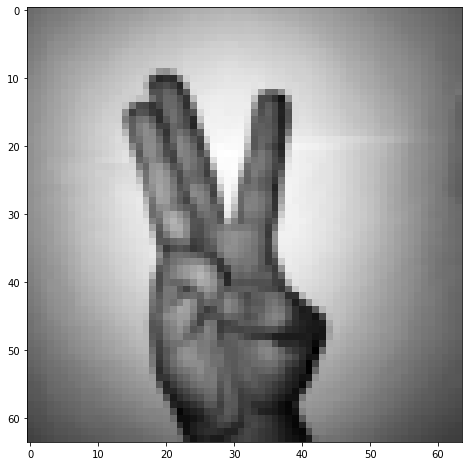

In [ ]:
# cose notate : 
# 636 c'é lo smalto  -- color filling
# 617 é inclinato    -- color filling
# 653 é inclinato
# 813 le dita sono attaccate -- edge recognition

img_index = 813
plt.imshow(X[img_index].reshape(64, 64), cmap='gray', interpolation='nearest')
likes = (model.custom_predict([X[img_index]]))
top_l = model.classes_[likes[0].argmax()]
if(top_l != 6):
    print(f"Top likelihood is: {top_l} for index {img_index}")
for i in range(len(model.classes_)) :
    class_l = likes[0][0][i]
    print(f"Likelihood for class {model.classes_[i]} : {class_l}")
